<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/07_question-answering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

**_이 노트북은 haystack 1.4.0을 사용하는 버전입니다._**

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7.2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 566 (delta 181), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (566/566), 48.97 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.13.0
Using datasets v2.10.1


INFO:haystack.modeling.model.optimization:apex not found, won't use it. See https://nvidia.github.io/apex/
ERROR:root:Failed to import 'magic' (from 'python-magic' and 'python-magic-bin' on Windows). FileTypeClassifier will not perform mimetype detection on extensionless files. Please make sure the necessary OS libraries are installed if you need this functionality.


Using haystack v1.4.0


In [2]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [3]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 질문 답변

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

## 리뷰 기반 QA 시스템 구축하기

### 데이터셋

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

In [4]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [5]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [7]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [8]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


In [9]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

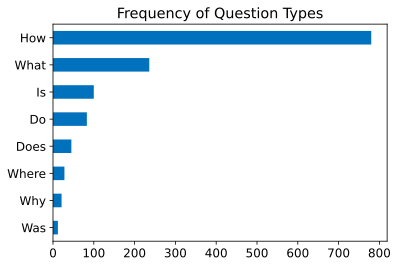

In [10]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [11]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 사이드바: 스탠포드 질문 답변 데이터셋

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

### 사이드바 끝

### 텍스트에서 답 추출하기

#### 범위 분류

<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/> 

#### QA를 위한 텍스트 토큰화

In [12]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [14]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [16]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [17]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [18]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


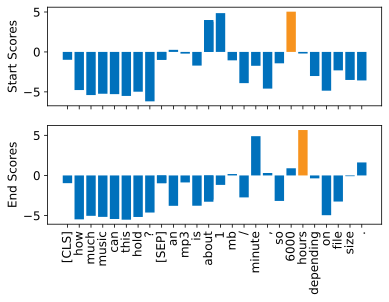

In [19]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [20]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


In [21]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516157388687134,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.220829576253891,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.102535180747509, 'start': 16, 'end': 27, 'answer': '1 MB/minute'}]

In [22]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기

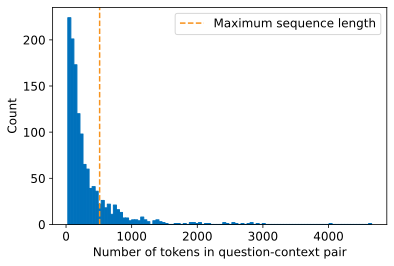

In [23]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

In [24]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [25]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [26]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### 헤이스택을 사용해 QA 파이프라인 구축하기

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

#### 문서 저장소 초기화하기

In [27]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [28]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스로 일래스틱서치를 실행합니다
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

In [29]:
# 또는 도커가 설치되어 있다면
from haystack.utils import launch_es

launch_es()

In [30]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "da1b9e54cdbe",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "WEEtA5s6Rt6n7zJXL4zp0w",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [31]:
# document_store --> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


In [32]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [33]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


#### 리트리버 초기화하기

헤이스택 1.4에서 `ElasticsearchRetriever`가 `BM25Retriever`로 바뀌었습니다. 여전히 버전 1.5에서 `ElasticsearchRetriever`를 사용할 수 있지만 향후 버전에서 삭제될 수 있습니다.

In [34]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [35]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [36]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never  ...'>


#### 리더 초기화하기

In [37]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find deepset/minilm-uncased-squad2 locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...
INFO:haystack.modeling.model.language_model:Loaded deepset/minilm-uncased-squad2
INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [38]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64809501171112,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293066054582596, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id':
'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


#### 모두 합치기

In [39]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [40]:
n_answers = 3
preds = pipe.run(query=query, 
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx].answer}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx].context}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 3:
해당 리뷰 텍스트: ...None...





## QA 파이프라인 개선하기

### 리트리버 평가하기

In [41]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [42]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가합니다
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [43]:
print(labels[0])

<Label: {'id': '627f7fcf-3387-4832-8744-856da206d2e1', 'query': 'What is the
tonal balance of these headphones?', 'document': {'content': "I have been a
headphone fanatic for thirty years and have owned and used a variety of
headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.
The Sony MDRV6 excells as the best value of any headphone that I've ever owned.
They are especially good at producing natural-sounding deep bass, and the
overall octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the velour pads from BeyerDynamic.  The pads tha

In [44]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

455개의 질문 답변 쌍을 로드했습니다.


In [45]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [46]:
# 다음처럼 원하는 top_k 값으로 파이프라인을 실행할 수 있습니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [47]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.96


In [48]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,content,gold_document_contents,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital camera and have found it to be a...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...so take these comments with...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one of the cheapest lens on the ma...,[],9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my old canon rebel xti from me (...,[],a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,"I fell in love with the lens the moment I started using it. sure, the build ...",[],0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,"I have read a lot of negative press about this lens, but I have to tell you ...","[I have read a lot of negative press about this lens, but I have to tell you...",47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


In [49]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k를 계산합니다
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k로 추론을 실행합니다
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

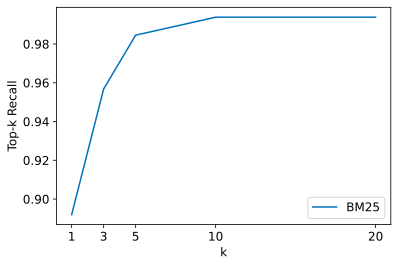

In [50]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

#### DPR

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

In [51]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-question_encoder-single-nq-base


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-ctx_encoder-single-nq-base


In [52]:
document_store.update_embeddings(retriever=dpr_retriever)

INFO:haystack.document_stores.elasticsearch:Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

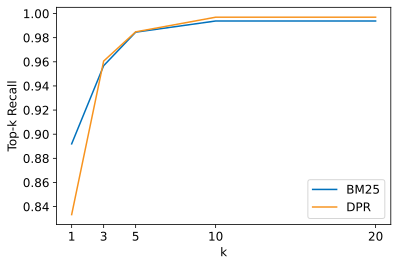

In [53]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### 리더 평가하기

In [54]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [55]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [56]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

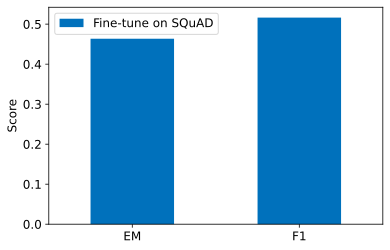

In [57]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### 도메인 적응

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

In [58]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링합니다
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열을 만듭니다
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링합니다
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문을 추가합니다
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가합니다
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가합니다
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [59]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [60]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs`를 만듭니다
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장합니다
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [61]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12599.31 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard 

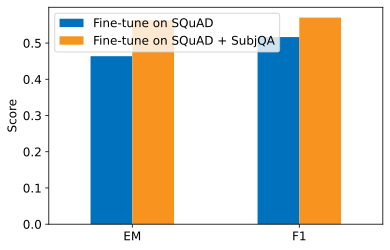

In [62]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [63]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find microsoft/MiniLM-L12-H384-uncased locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded microsoft/MiniLM-L12-H384-uncased


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [64]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12178.22 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard 

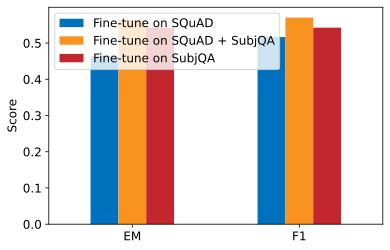

In [65]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### 전체 QA 파이프라인 평가하기

In [66]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

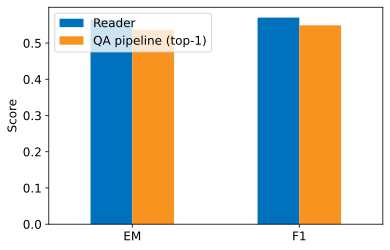

In [67]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

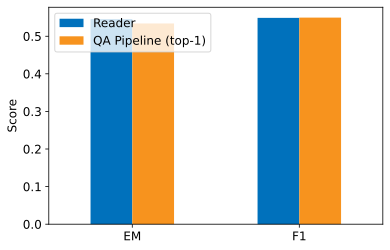

In [68]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻습니다
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됩니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출합니다
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## 추출적 QA를 넘어서

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>

In [69]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

In [70]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [71]:
def generate_answers(query, top_k_generator=3): 
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"질문: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

In [72]:
generate_answers(query)

/usr/local/lib/python3.8/dist-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


질문: Is it good for reading?

답변 1:  the screen is absolutely beautiful
답변 2:  the Screen is absolutely beautiful
답변 3:  Kindle fire


In [73]:
generate_answers("What is the main drawback?")

질문: What is the main drawback?

답변 1:  the price
답변 2:  no flash support
답변 3:  the cost


## 결론

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/> 